In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_csv("Trade_18_19.csv")
df_18 = df.loc[df["Year"] == 2018].reset_index()
df_19 = df.loc[df["Year"] == 2019].reset_index()


In [2]:
'''
linear regression strategy
take W = 5, 6,...,30
if PW+1 > PW:
buy in if not having a position/ keep if having a long position/ close the short position.
if PW+1 > PW:
sell short if not having a position/ keep if having a short position/ close the long position.
if PW+1 = PW:
do nothing
'''
class Linear_reg:
    def __init__(self, w, days, adj_close):
        self.w = w
        self.days = days
        self.adj_close = adj_close
        
    def linear_reg_predict(self, day):
        start = day
        end = day + self.w
        train_x = self.days[start:end]
        train_y = self.adj_close[start:end]

        reg = LinearRegression().fit(train_x, train_y)
        predict_close = reg.predict(self.days[start:end+1])
        w_close = train_y[-1]

        return predict_close, w_close, end
    
    def linear_reg_strategy(self):

        position = "no"
        share = 0
        action_price = 0
        account_balance = 100 # initial invest
        long_count = 0
        short_count = 0
        long_balance = 0
        short_balance = 0
        long_day = 0
        short_day = 0
        long_days = []
        short_days = []

        for day in range(len(self.days)):
            predict = self.linear_reg_predict(day)
            predict_close = predict[0][-1]
            w_close = predict[1]
            end = predict[2]
            if end == self.days[-1]:
                break

            if predict_close > w_close:
                if position == "no": # buy in
                    share = account_balance / w_close
                    action_price = w_close
                    position = "long"
                    long_count += 1
                    long_day += 1
                elif position == "long": # keep the position
                    long_count += 1
                    long_day += 1
                elif position == "short": # close the short position
                    short_profit_loss = (action_price - w_close) * share
                    account_balance += short_profit_loss
                    short_balance += short_profit_loss
                    position = "no"
                    short_days.append(short_day)
                    short_day = 0

            elif predict_close < w_close:
                if position == "no": # sell short
                    share = account_balance / w_close
                    action_price = w_close
                    position = "short"
                    short_count += 1
                    short_day += 1
                elif position == "short": # keep the position
                    short_count += 1
                    short_day += 1
                elif position == "long": # close the long position
                    long_profit_loss = (w_close - action_price) * share
                    account_balance += long_profit_loss
                    long_balance += long_profit_loss
                    position = "no"
                    long_days.append(long_day)
                    long_day = 0

            elif predict_close == w_close:
                    continue

        return account_balance, long_count, short_count, long_balance, short_balance, long_days, short_days

### 1. Find the best size of W with 2018 data

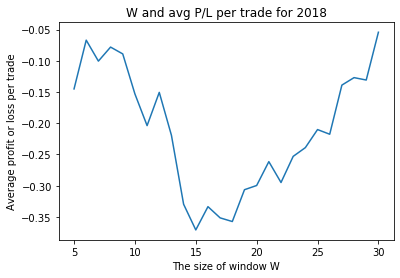

The best size of W is 30


In [3]:
adj_close_18 = df_18[["Adj Close"]].values
days_18 = np.array(range(len(df_18["index"]))).reshape(-1, 1)
window_w = [ i for i in range(5,31)]

w_average_profit = []
for w in window_w:
    linear_18 = Linear_reg(w, days_18, adj_close_18)
    strategy_18 = linear_18.linear_reg_strategy()
    total_profit_loss = strategy_18[0] - 100 # initial invest
    trade_count = strategy_18[1] + strategy_18[2]
    avg_profit_per_trade = total_profit_loss / trade_count
    w_average_profit.append(avg_profit_per_trade)

plt.plot(window_w, w_average_profit)
plt.xlabel("The size of window W")
plt.ylabel("Average profit or loss per trade")
plt.title("W and avg P/L per trade for 2018")
plt.show()
opt_w_18 = window_w[w_average_profit.index(max(w_average_profit))]
print("The best size of W is", opt_w_18)

### 2. Calculate the R squared values for 2019, with the optimal W value from 2018

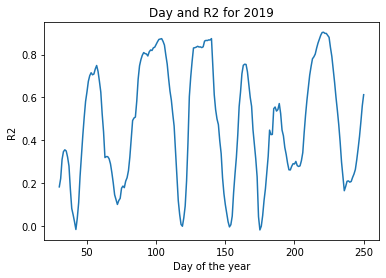

In [4]:
optimal_w = opt_w_18
days_19 = np.array(range(len(df_19["index"]))).reshape(-1, 1)
adj_close_19 = df_19[["Adj Close"]].values


r2_score_list = []
predict_list = []
for day in range(len(days_19)):
    linear_19 = Linear_reg(optimal_w, days_19, adj_close_19)
    predict_19 = linear_19.linear_reg_predict(day)
    predict_y = predict_19[0][-1]
    predict_list.append(predict_y)
    predict_index = predict_19[2]
    if predict_index == days_19[-1]:
        break
    test_day_y = adj_close_19[day:predict_index+1]
    predict_day_y = predict_19[0]
    r2 = r2_score(test_day_y , predict_day_y)
    r2_score_list.append(r2)

w_days = list(range(optimal_w, len(df_19["index"])-1))
plt.plot(w_days, r2_score_list)
plt.xlabel("Day of the year")
plt.ylabel("R2")
plt.title("Day and R2 for 2019")
plt.show()

In [5]:
test_y_all = adj_close_19[optimal_w:]
avg_r2 = r2_score(test_y_all, np.array(predict_list))
print("The R squared of all prediction is", round(avg_r2, 2))

The R squared of all prediction is 0.89


### 3. How many long and short position transactions for 2019?

In [6]:
strategy_19 = linear_19.linear_reg_strategy()
print("Long position:", strategy_19[1],\
     "\nShort position:", strategy_19[2])

Long position: 84 
Short position: 108


### 4. What is the average profit/loss per "long position" trade and per "short position" trade in 2019?

In [7]:
profit_per_long = strategy_19[3] / strategy_19[1]
profit_per_short = strategy_19[4] / strategy_19[2]
print("Avg profit/loss per long position:", round(profit_per_long[0],2),\
     "\nAvg profit/loss per short position:", round(profit_per_short[0],2))

Avg profit/loss per long position: 0.18 
Avg profit/loss per short position: -0.16


### 5. What is the average number of days for long position and short position transactions in 2019?

In [8]:
avg_long_days = np.mean(strategy_19[-2])
avg_short_days = np.mean(strategy_19[-1])
print("Avg number of days for long position:", round(avg_long_days,2),\
     "\nAvg number of days for short position:", round(avg_short_days,2))

Avg number of days for long position: 6.46 
Avg number of days for short position: 6.0


### 6. Compare 2018 and 2019

In [9]:
total_profit_loss_19 = strategy_19[0] - 100
trade_count_19 = strategy_19[1] + strategy_19[2]
avg_profit_per_trade_19 = total_profit_loss_19  / trade_count_19
avg_profit_per_trade_18 = max(w_average_profit)
print("Avg profit or loss per trade in 2019: ", avg_profit_per_trade_19[0],\
     "\nAvg profit or loss per trade in 2018: ", avg_profit_per_trade_18[0])

Avg profit or loss per trade in 2019:  -0.009992211165982553 
Avg profit or loss per trade in 2018:  -0.0543642971541135


2019 did not loss as much as 2018